Importing models

In [ ]:
pip show scikit-learn

Name: scikit-learn
Version: 1.2.2
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: /usr/local/lib/python3.10/dist-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: bigframes, fastai, imbalanced-learn, librosa, mlxtend, qudida, sklearn-pandas, yellowbrick


In [ ]:
!pip install tensorflow scikit-learn scikeras

INFO: pip is looking at multiple versions of scikeras to determine which version is compatible with other requirements. This could take a while.


In [ ]:
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt, keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, balanced_accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import pickle
import joblib
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

Importing datasets

In [ ]:
train_data = pd.read_csv("/content/drive/MyDrive/Manuscrip_preparation/compounds/model.csv")
test_data = pd.read_csv("/content/drive/MyDrive/Manuscrip_preparation/compounds/testing.csv")

Read training and testing data

In [ ]:
def one_hot_encode_target(df, target_col):
    df = pd.concat([df, pd.get_dummies(df[target_col])], axis='columns')
    df = df.drop([target_col, 'Inactive'], axis='columns')
    return df

train_data = one_hot_encode_target(train_data, 'PUBCHEM_ACTIVITY_OUTCOME')
test_data = one_hot_encode_target(test_data, 'PUBCHEM_ACTIVITY_OUTCOME')

In [ ]:
train_data

,CID,Col_1,Col_41,Col_79,Col_80,Col_81,Col_94,Col_117,Col_119,Col_140,...,Col_1911,Col_1917,Col_1937,Col_1959,Col_1970,Col_2004,Col_2006,Col_2016,Col_2020,Active
0,16190963.0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,False
1,2390959.0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,True
2,1811460.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,False
3,49790185.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,False
4,46942591.0,1,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
965,Resampled_359,1,1,1,1,0,1,1,1,1,...,1,1,1,1,1,0,1,1,1,True
966,Resampled_360,1,1,1,1,1,0,1,1,1,...,1,1,1,1,1,0,1,1,1,True
967,Resampled_361,1,1,1,1,1,0,1,1,1,...,1,1,1,1,1,1,1,1,1,True
968,Resampled_362,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,1,1,1,True


In [ ]:
X_train = train_data.drop(['Active', 'CID'], axis=1)
y_train = train_data['Active']

X_test = test_data.drop(['Active','CID'], axis=1)
y_test = test_data['Active']

#X_filterd = fitered_test.drop(['Active', 'CID'], axis=1)
#y_filtered = fitered_test['Active']

In [ ]:
y_train.value_counts() #shape of dependent variable

Active
False    485
True     485
Name: count, dtype: int64

In [ ]:
y_test.value_counts()

Active
False    215
True      46
Name: count, dtype: int64

In [ ]:
#scale tarining data down for better learning and performance

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
#X_filterd = sc.transform(X_filterd)

pickle.dump(sc, open('/content/drive/MyDrive/Manuscrip_preparation/scaler.pkl','wb'))

sc = pickle.load(open('/content/drive/MyDrive/Manuscrip_preparation/scaler.pkl','rb'))

In [ ]:
X_test

array([[-0.92066229, -0.9111469 , -0.76652552, ..., -0.7463125 ,
        -0.74798765, -0.7463125 ],
       [ 1.08617461, -0.9111469 , -0.76652552, ..., -0.7463125 ,
        -0.74798765, -0.7463125 ],
       [ 1.08617461, -0.9111469 , -0.76652552, ..., -0.7463125 ,
        -0.74798765, -0.7463125 ],
       ...,
       [-0.92066229, -0.9111469 , -0.76652552, ..., -0.7463125 ,
        -0.74798765, -0.7463125 ],
       [-0.92066229, -0.9111469 , -0.76652552, ..., -0.7463125 ,
        -0.74798765, -0.7463125 ],
       [-0.92066229,  1.09751786, -0.76652552, ..., -0.7463125 ,
        -0.74798765, -0.7463125 ]])

In [ ]:
X_train.shape

(970, 146)

Scoring

In [ ]:
scoring = {'accuracy':'accuracy',
           'precision':'precision',
           'recall':'recall',
           'f1':'f1',
           'roc_auc':'roc_auc',
           'mcc':make_scorer(matthews_corrcoef),
           'bal_acc':make_scorer(balanced_accuracy_score)}

In [ ]:
def CV_performance(model_name):
    cv_results = pd.DataFrame(model_name.cv_results_).round(8)
    best_score = cv_results['mean_test_accuracy'].max().round(8)
    best_params = model_name.best_params_
    metrics = {'Precision': 'precision', 'Recall': 'recall', 'F1': 'f1', 'Balanced accuracy': 'bal_acc', 'ROC-AUC': 'roc_auc', 'MCC': 'mcc'}
    row_dict = {'Accuracy': best_score}
    best_params = model_name.best_params_
    print(f"Best accuracy: {best_score}")
    print(f"Best parameters: {best_params}")
    for metric_name, metric_key in metrics.items():
        if 'mean_test_' + metric_key in cv_results.columns:
            row_dict[metric_name] = cv_results['mean_test_' + metric_key].iloc[cv_results['mean_test_accuracy'].idxmax()]
    return pd.DataFrame([row_dict])

def Test_performance(model_name):
    y_pred = model_name.predict(X_test)
    performance = pd.DataFrame({
        'Name': [model_name],
        'Accuracy': [accuracy_score(y_test, y_pred).round(3)],
        'Precision': [precision_score(y_test, y_pred, average='binary').round(3)],
        'Recall': [recall_score(y_test, y_pred).round(3)],
        'F1-score': [f1_score(y_test, y_pred).round(3)],
        'Balanced Accuracy': [balanced_accuracy_score(y_test, y_pred).round(3)],
        'ROC AUC': [(roc_auc_score(y_test, model_name.predict_proba(X_test)[:,1])).round(3)],
        'MCC': [matthews_corrcoef(y_test, y_pred).round(3)]
    })
    print(classification_report(y_test, y_pred, target_names=['Inactive', 'Active']))
    print(confusion_matrix(y_test, y_pred))
    return performance

ROC CURVE

In [ ]:
def roc_plot(*models):
    model_names = ['ANN', 'RF', 'LR', 'XGBOOST', 'SVM', 'KNN', 'DT']
    plt.style.use('seaborn')
    fig, axs = plt.subplots(2, 3, figsize=(8, 8))

    for i, model in enumerate(models):
        row = i // 3
        col = i % 3
        model_probs = model.predict_proba(X_test)[:,1]
        roc_auc = roc_auc_score(y_test, model_probs).round(3)
        model_fpr, model_tpr, _ = roc_curve(y_test, model_probs)

        label = model_names[i] + ' (AUROC = %0.3f)' % roc_auc
        axs[row, col].plot(model_fpr, model_tpr, label=label)
        axs[row, col].plot([0, 1], [0, 1], linestyle='--', color='black', label='Random Chance')
        axs[row, col].set_xlabel('False Positive Rate')
        axs[row, col].set_ylabel('True Positive Rate')
        axs[row, col].set_title(model_names[i])
        axs[row, col].legend(loc='lower right')

    fig.suptitle('ROC Curve for Multiple Models', fontsize=20)
    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/Manuscrip_preparation/roc_auc_figure.pdf')
    plt.show()
    return None

ANN

In [ ]:
def ANN_classifier(optimizer='adam', random_seed=18):
    np.random.seed(random_seed)
    tf.random.set_seed(random_seed)
    classifier = Sequential()
    classifier.add(Dense(75, kernel_initializer="uniform", activation="relu", input_dim=146))
    classifier.add(Dropout(rate=0.1))
    classifier.add(Dense(35, kernel_initializer='uniform', activation='relu'))
    classifier.add(Dropout(rate=0.01))
    classifier.add(Dense(15, kernel_initializer='uniform', activation='relu'))
    classifier.add(Dropout(rate=0.01))
    classifier.add(Dense(1, kernel_initializer="uniform", activation="sigmoid"))
    classifier.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=['accuracy'])
    return classifier

classifier = KerasClassifier(model=ANN_classifier, verbose=0)

params = {
   'optimizer':['adam', 'sgd', 'rmsprop'],
    'epochs':[50, 100, 150],
    'batch_size':[32, 64],
}

ANN_model = GridSearchCV(estimator=classifier, param_grid=params, scoring=scoring ,n_jobs=-1, cv=2, refit = 'accuracy')

ANN_model.fit(X_train,y_train)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


GridSearchCV(cv=2,
             estimator=KerasClassifier(model=<function ANN_classifier at 0x7e816da44670>, verbose=0),
             n_jobs=-1,
             param_grid={'batch_size': [32, 64], 'epochs': [50, 100, 150],
                         'optimizer': ['adam', 'sgd', 'rmsprop']},
             refit='accuracy',
             scoring={'accuracy': 'accuracy',
                      'bal_acc': make_scorer(balanced_accuracy_score),
                      'f1': 'f1', 'mcc': make_scorer(matthews_corrcoef),
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

In [ ]:
CV_performance(ANN_model)

Best accuracy: 0.96494845
Best parameters: {'batch_size': 32, 'epochs': 150, 'optimizer': 'adam'}


,Accuracy,Precision,Recall,F1,Balanced accuracy,ROC-AUC,MCC
0,0.964948,0.941381,0.991736,0.965888,0.964957,0.991565,0.931261


In [ ]:
ANN = Test_performance(ANN_model)
ANN

              precision    recall  f1-score   support

    Inactive       0.99      0.97      0.98       215
      Active       0.86      0.93      0.90        46

    accuracy                           0.96       261
   macro avg       0.92      0.95      0.94       261
weighted avg       0.96      0.96      0.96       261

[[208   7]
 [  3  43]]


,Name,Accuracy,Precision,Recall,F1-score,Balanced Accuracy,ROC AUC,MCC
0,"GridSearchCV(cv=2,\n estimator=Ker...",0.962,0.86,0.935,0.896,0.951,0.992,0.874


SVM

In [ ]:
# Define parameter grid for SVM
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
}

# initializing a GridSearchCV object with the SVM model, parameter grid, and desired scoring metrics
svm_model = GridSearchCV(SVC(probability=True, random_state=18), param_grid= param_grid, scoring=scoring, n_jobs=-1, refit = 'accuracy', cv= 10)  #10 folds cross validation

# fitting the model for grid search on the training data
svm_model.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=SVC(probability=True, random_state=18), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             refit='accuracy',
             scoring={'accuracy': 'accuracy',
                      'bal_acc': make_scorer(balanced_accuracy_score),
                      'f1': 'f1', 'mcc': make_scorer(matthews_corrcoef),
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

SVM CV PERFORMANCE

In [ ]:
CV_performance(svm_model)

Best accuracy: 0.99587629
Best parameters: {'C': 100, 'gamma': 'scale', 'kernel': 'poly'}


,Accuracy,Precision,Recall,F1,Balanced accuracy,ROC-AUC,MCC
0,0.995876,0.991918,1.0,0.995897,0.995918,1.0,0.991878


SVM EXTERNAL VALIDATION

In [ ]:
SVM = Test_performance(svm_model)
SVM

              precision    recall  f1-score   support

    Inactive       0.97      1.00      0.98       215
      Active       0.98      0.87      0.92        46

    accuracy                           0.97       261
   macro avg       0.97      0.93      0.95       261
weighted avg       0.97      0.97      0.97       261

[[214   1]
 [  6  40]]


,Name,Accuracy,Precision,Recall,F1-score,Balanced Accuracy,ROC AUC,MCC
0,"GridSearchCV(cv=10, estimator=SVC(probability=...",0.973,0.976,0.87,0.92,0.932,0.971,0.906


XGBOOST


In [ ]:
param = {
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 4, 5],
    "min_child_weight": [3, 5],
}

xgb_model = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, seed=18), param_grid = param, scoring=scoring ,n_jobs=-1, cv=10, refit = 'accuracy')

# fitting the model for grid search
xgb_model.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1,...
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5], 'min_child_weight': [3, 5]},
             refit='accuracy',
             scoring={'accuracy': 'accuracy',
                      'bal_acc': make_scorer(balanced_accuracy_score),
                      'f1': 'f1', 'mcc': make_scorer(matthews_corrcoef),
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

In [ ]:
CV_performance(xgb_model)

Best accuracy: 0.98659794
Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3}


,Accuracy,Precision,Recall,F1,Balanced accuracy,ROC-AUC,MCC
0,0.986598,0.985628,0.987628,0.986576,0.986607,0.997747,0.973298


In [ ]:
XGB = Test_performance(xgb_model)
XGB

              precision    recall  f1-score   support

    Inactive       0.98      0.99      0.98       215
      Active       0.95      0.89      0.92        46

    accuracy                           0.97       261
   macro avg       0.97      0.94      0.95       261
weighted avg       0.97      0.97      0.97       261

[[213   2]
 [  5  41]]


,Name,Accuracy,Precision,Recall,F1-score,Balanced Accuracy,ROC AUC,MCC
0,"GridSearchCV(cv=10,\n estimator=XG...",0.973,0.953,0.891,0.921,0.941,0.987,0.906


Random forest

In [ ]:
#hyperparameter tuning
param = {

}

RF_model = GridSearchCV(estimator=RandomForestClassifier(random_state = 18), param_grid = param, scoring=scoring , n_jobs=-1, cv=10, refit = 'accuracy')
RF_model.fit(X_train, y_train)  #fit training data to model

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=18),
             n_jobs=-1, param_grid={}, refit='accuracy',
             scoring={'accuracy': 'accuracy',
                      'bal_acc': make_scorer(balanced_accuracy_score),
                      'f1': 'f1', 'mcc': make_scorer(matthews_corrcoef),
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

Random forest performance evaluation

In [ ]:
pd.get_option("display.max_rows")
CV_performance(RF_model)

Best accuracy: 0.99896907
Best parameters: {}


,Accuracy,Precision,Recall,F1,Balanced accuracy,ROC-AUC,MCC
0,0.998969,0.997959,1.0,0.998969,0.99898,0.999957,0.997959


In [ ]:
RF = Test_performance(RF_model)
RF

              precision    recall  f1-score   support

    Inactive       0.99      1.00      0.99       215
      Active       1.00      0.93      0.97        46

    accuracy                           0.99       261
   macro avg       0.99      0.97      0.98       261
weighted avg       0.99      0.99      0.99       261

[[215   0]
 [  3  43]]


,Name,Accuracy,Precision,Recall,F1-score,Balanced Accuracy,ROC AUC,MCC
0,"GridSearchCV(cv=10, estimator=RandomForestClas...",0.989,1.0,0.935,0.966,0.967,0.991,0.96


Logistic regression

In [ ]:
#tune hyperparameter
parameters = [{'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']},
              ]

logistic_model = GridSearchCV(estimator = LogisticRegression(random_state=18),
                           param_grid = parameters,
                           scoring = scoring,
                           cv = 10, n_jobs=-1, refit = 'accuracy',
                           verbose=0)

logistic_model.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(random_state=18), n_jobs=-1,
             param_grid=[{'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                     'saga']}],
             refit='accuracy',
             scoring={'accuracy': 'accuracy',
                      'bal_acc': make_scorer(balanced_accuracy_score),
                      'f1': 'f1', 'mcc': make_scorer(matthews_corrcoef),
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

LR PERFORMANCE EVALUATION

In [ ]:
CV_performance(logistic_model)

Best accuracy: 0.95257732
Best parameters: {'solver': 'liblinear'}


,Accuracy,Precision,Recall,F1,Balanced accuracy,ROC-AUC,MCC
0,0.952577,0.939318,0.968963,0.953336,0.952594,0.990944,0.906779


In [ ]:
LR = Test_performance(logistic_model)
LR

              precision    recall  f1-score   support

    Inactive       0.99      0.93      0.96       215
      Active       0.75      0.96      0.84        46

    accuracy                           0.93       261
   macro avg       0.87      0.94      0.90       261
weighted avg       0.95      0.93      0.94       261

[[200  15]
 [  2  44]]


,Name,Accuracy,Precision,Recall,F1-score,Balanced Accuracy,ROC AUC,MCC
0,"GridSearchCV(cv=10, estimator=LogisticRegressi...",0.935,0.746,0.957,0.838,0.943,0.989,0.808


<ipython-input-39-c784fe5451f4>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


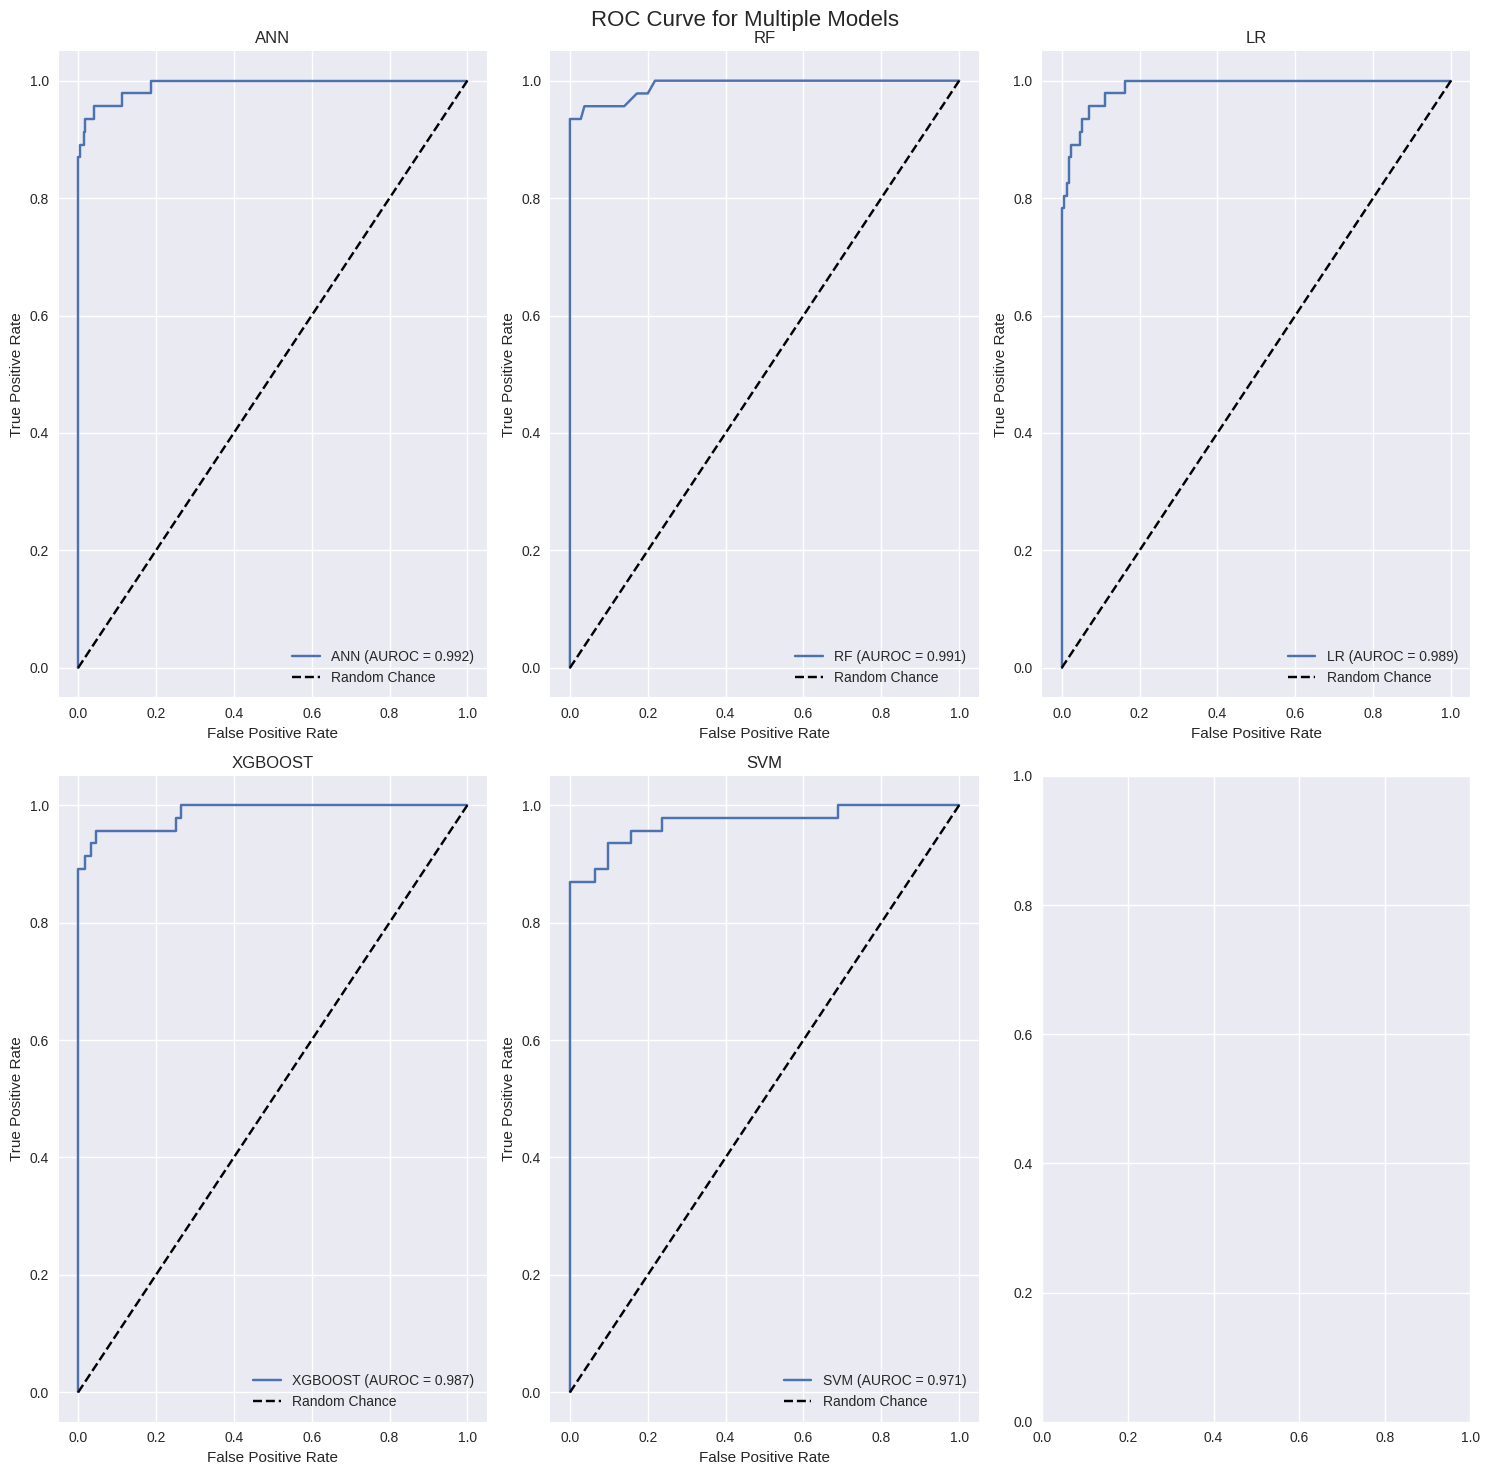

In [ ]:
roc_plot(ANN_model, RF_model, logistic_model, xgb_model, svm_model)
#roc_plot(RF_model, xgb_model, svm_model)

Display final result of all models using pandas list


In [ ]:
test_performance = pd.concat([ANN, SVM, LR, XGB, RF], axis=0)
test_performance['Name'] = ['ANN', 'SVM', 'LR', 'XGB', 'RF']
test_performance

,Name,Accuracy,Precision,Recall,F1-score,Balanced Accuracy,ROC AUC,MCC
0,ANN,0.962,0.860,0.935,0.896,0.951,0.992,0.874
0,SVM,0.973,0.976,0.870,0.920,0.932,0.971,0.906
0,LR,0.935,0.746,0.957,0.838,0.943,0.989,0.808
0,XGB,0.973,0.953,0.891,0.921,0.941,0.987,0.906
0,RF,0.989,1.000,0.935,0.966,0.967,0.991,0.960


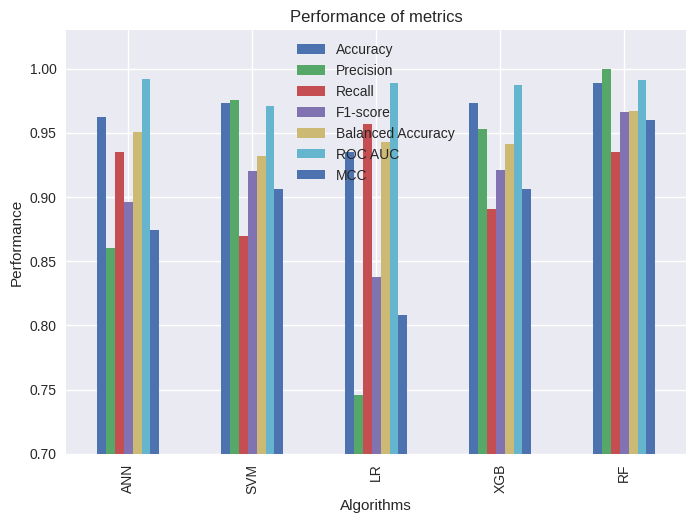

In [ ]:
test_performance.plot(kind = 'bar', x="Name")
plt.title("Performance of metrics")
plt.ylim(0.7, 1.03)
plt.xlabel("Algorithms")
plt.ylabel("Performance")
plt.savefig('/content/drive/MyDrive/Manuscrip_preparation/performance.pdf')

Save models as pickle for API

In [ ]:
#SAVE MODEL
import pickle
pickle.dump(RF_model, open('/content/drive/MyDrive/Manuscrip_preparation/RF_model.pkl', 'wb'))
pickle.dump(logistic_model, open('/content/drive/MyDrive/Manuscrip_preparation/logic_model.pkl', 'wb'))
pickle.dump(svm_model, open('/content/drive/MyDrive/Manuscrip_preparation/svm_model.pkl', 'wb'))
pickle.dump(xgb_model, open('/content/drive/MyDrive/Manuscrip_preparation/xgb_model.pkl', 'wb'))
pickle.dump(ANN_model, open('/content/drive/MyDrive/Manuscrip_preparation/ANN_model.pkl', 'wb'))